# Report on CTM MILP Model - Simplex

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from pprint import pprint
import time
import ternary

from ctmmodels.const import *
from batchrunners.const import *
from batchrunners.generators.graphs import GraphGenerator

In [3]:
IMAGE_PATH = 'graphs/simplex_greentimes/'
DF_PATH = 'dataframes/'

## Intersection Cell Network

![title](img/4leg-intersection.png)

## 1. Plotting delay and throughput on the simplex

In [3]:
df = pd.read_pickle(DF_PATH + "asymm_demand_ringbarrier/results_simplex_d(450, 450).pkl")

In [4]:
df.head()

,demand,runtime,delay,throughput,objective_value,alpha,beta,gamma
0,"(450, 450)",1.785486,921.191983,43.654008,-1914.135021,0.0,0.0,1.0
1,"(450, 450)",3.872170,922.643460,44.556962,-1739.388186,0.0,0.1,0.9
2,"(450, 450)",4.710122,939.124473,44.556962,-1564.641350,0.0,0.2,0.8
3,"(450, 450)",3.657952,922.331224,44.556962,-1389.894515,0.0,0.3,0.7
4,"(450, 450)",2.007494,929.278481,44.556962,-1215.147679,0.0,0.4,0.6


In [5]:
import ternary

In [87]:
df_nparr = df.values
delay_dict = {}
thru_dict = {}
runtime_dict = {}
obj_dict = {}

for row in df_nparr:
    runtime_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[1]
    delay_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[2]
    thru_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[3]
    obj_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[4]

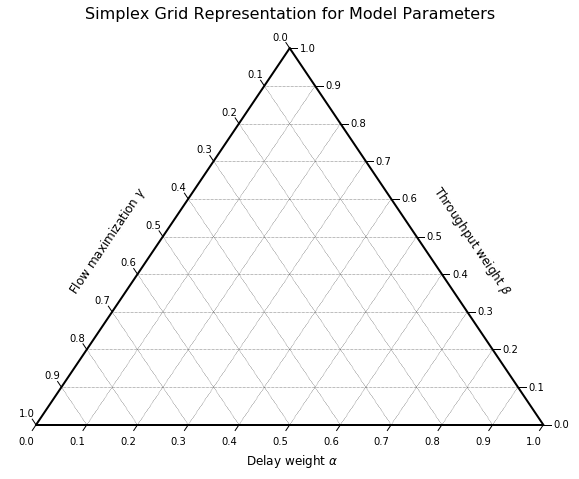

In [20]:
scale = 1.0
mult = 0.1

fig, tax = ternary.figure(scale=scale)
fig.set_size_inches(10, 8)

tax.boundary(linewidth=2.0)
tax.gridlines(color="black", multiple=mult)

tax.set_title("Simplex Grid Representation for Model Parameters", fontsize=16, pad=15)
tax.bottom_axis_label("Delay weight $\\alpha$", fontsize=12, offset=-0.02)
tax.right_axis_label("Throughput weight $\\beta$", fontsize=12, offset=0.12)
tax.left_axis_label("Flow maximization $\\gamma$", fontsize=12, offset=0.12)

tax.ticks(axis='lbr', linewidth=1, multiple=mult, tick_formats="%.1f", offset=0.015)
tax.clear_matplotlib_ticks()
tax.get_axes().axis('off')
tax._redraw_labels()

#tax.heatmap(obj_dict, style="triangular", cbarlabel="Computed Objective Value")

point1=[
    (8, 1, 1),
    (1, 8, 1),
    (1, 1, 8),
    (4.5, 4.5, 1),
    (1, 4.5, 4.5),
    (4.5, 1, 4.5),
    (10.0/3.0, 10.0/3.0, 10.0/3.0),
]

point2=[
    (1, 0, 0),
    (0, 1, 0),
    (0, 0, 1),
    (0.5, 0.5, 0),
    (0, 0.5, 0.5),
    (0.5, 0, 0.5),
    (1.0/3.0, 1.0/3.0, 1.0/3.0)
]
#tax.scatter(point2, marker='D', color='green', label=r"$(\frac{1}{3},\frac{2}{3},0)$")

plt.savefig('simplex-grid.png')

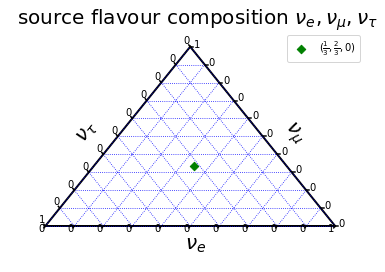

In [68]:
import pylab as p
figure, d=ternary.figure(scale=1)

d.boundary(linewidth=2.0)
d.gridlines(multiple=0.1,color="blue",linewidth=0.8)

d.set_title(r"source flavour composition $\nu_e,\nu_\mu,\nu_\tau$",fontsize=20)
d.left_axis_label(r"$\nu_\tau$",fontsize=20,offset=0.12)
d.right_axis_label(r"$\nu_\mu$",fontsize=20)
d.bottom_axis_label(r"$\nu_e$",fontsize=20)
d._redraw_labels()

d.ticks(axis='brl',multiple=0.1)
p.axis('off')
point1=[(0.34669820676138435,0.3336302826666826,0.31967151057193305)]
d.scatter(point1, marker='D', color='green', label=r"$(\frac{1}{3},\frac{2}{3},0)$")
d.resize_drawing_canvas(scale=1.05)
d.legend()
d.show()

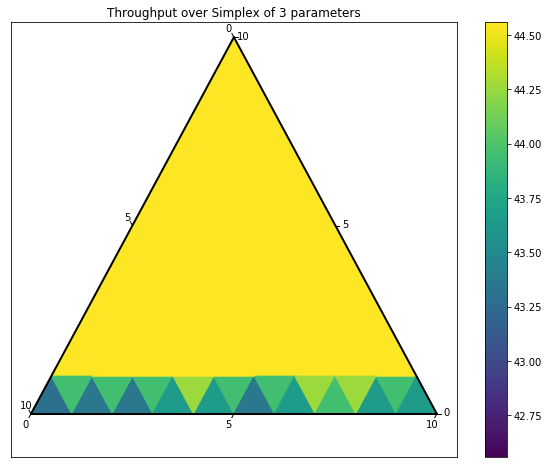

In [17]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(thru_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Throughput over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

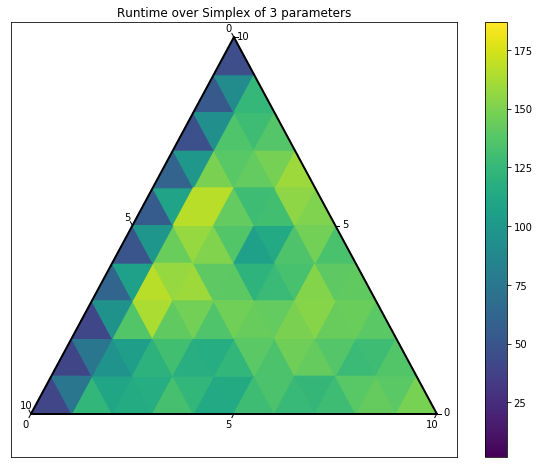

In [18]:
scale = 10

figure, tax = ternary.figure(scale=10)
figure.set_size_inches(10, 8)
tax.heatmap(runtime_dict, style="triangular")
tax.boundary(linewidth=2.0)
tax.set_title("Runtime over Simplex of 3 parameters")
tax.ticks(axis='lbr', linewidth=1, multiple=5)
tax.clear_matplotlib_ticks()
tax.show()

In [25]:
time_range = 30
time_ticks = np.arange(0, time_range+1, 1)

parameters = {
    'r_left': 1.0/3.0,
    'r_through': 1.0/3.0,
    'r_right': 1.0/3.0,
    'sat_flow_rate': 1800,
    'time_range': time_range,
    'time_step': 2,
    'g_min': 6,
    'g_max': 20
}

_approach = 0

_approach_terms = [
    'Left',
    'Through',
    'Right'
]

_cell_path = [
    (CELL_SOURCE,0,_approach),
    (CELL_NORMAL,0,_approach),
    (CELL_NORMAL,1,_approach),
    (CELL_NORMAL,2,_approach),
    (CELL_MOVEMENT,THROUGH_TURN,_approach),
    S_mapping((CELL_MOVEMENT,THROUGH_TURN,_approach))[0]
]

def movement_paths(approach):
    return [
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,LEFT_TURN,approach),
            S_mapping((CELL_MOVEMENT,LEFT_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,THROUGH_TURN,approach),
            S_mapping((CELL_MOVEMENT,THROUGH_TURN,approach))[0]
        ],
        [
            (CELL_SOURCE,0,approach),
            (CELL_NORMAL,0,approach),
            (CELL_NORMAL,1,approach),
            (CELL_NORMAL,2,approach),
            (CELL_MOVEMENT,RIGHT_TURN,approach),
            S_mapping((CELL_MOVEMENT,RIGHT_TURN,approach))[0]
        ]
    ]

In [26]:
all_phases = [intToBinTuple(x) for x in range(8)]
all_phases_labels = [
    "Left, Westbound",
    "Through, Eastbound",
    "Left, Southbound",
    "Through, Southbound",
    "Left, Eastbound",
    "Through, Westbound",
    "Left, Northbound",
    "Through, Northbound",
]

def plot_greentime(dfg, title, headless=True, filename='greentime.png'):
    dfg_map = dfg.pivot(index='timestep', columns='cell', values='is_green')

    fig, axs = plt.subplots(8,1,figsize=(18,18), sharey=True)

    for ndx, t in enumerate(all_phases):
        sns.lineplot(data=dfg_map[t], ax=axs[ndx])
        axs[ndx].text(0.01,.5,all_phases_labels[ndx],
            horizontalalignment='left',
            transform=axs[ndx].transAxes,
            fontsize='large')
        axs[ndx].set_xticks(time_ticks, minor=False)
    
    fig.suptitle(title, fontsize=18)
    
    if headless:
        fig.savefig(IMAGE_PATH + filename)
        plt.close(fig)

In [20]:
def generate_simplex(steps=10):
    simplex = [(a,b,steps-(a+b)) for a in range(steps+1) for b in range(steps - a + 1)]
    normalized = []
    for point in simplex:
        normalized.append((float(point[0]) / steps, float(point[1]) / steps, float(point[2]) / steps))
    return normalized

def load_greentime_set(demand, simplex):
    simplex_greentimes = {}
    for point in simplex:
        simplex_greentimes[point] = pd.read_pickle(DF_PATH + "triple_simplex/greentimes/greentimes_d{}_a{}_b{}_c{}.pkl".format(demand, point[0], point[1], point[2]))
    
    return simplex_greentimes

In [21]:
def process_greentime_set(demand, simplex):
    for point in simplex:
        dfg = pd.read_pickle(DF_PATH + "triple_simplex/greentimes/greentimes_d{}_a{}_b{}_c{}.pkl".format(demand, point[0], point[1], point[2]))
        plot_greentime(dfg, "Green times for {} vphpl (a={}, b={}, c={})".format(demand, point[0], point[1], point[2]), filename='greentime_d{}_a{}_b{}_c{}.png'.format(demand, point[0], point[1], point[2]))


In [27]:
process_greentime_set(900, generate_simplex())

In [3]:
gg = GraphGenerator(
    simplex_range=10,
    folder='asymm_demand',
    headless=True
)

In [4]:
demands = [(x,y) for x in range(450,1801,150) for y in range(450,1801,150) if y > x]

single_demands = [x for x in range(450,1801,150)]

len(single_demands)

10

{(0.0, 5.0, 5.0): 1150.7566807313644, (1.0, 6.0, 3.0): 1065.212376933896, (2.0, 0.0, 8.0): 1065.3375527426163, (2.0, 3.0, 5.0): 1065.2123769338962, (4.0, 0.0, 6.0): 1065.462728551336, (1.0, 0.0, 9.0): 1065.520393811533, (0.0, 8.0, 2.0): 1161.7848101265827, (3.0, 6.0, 1.0): 1065.2123561005262, (1.0, 4.0, 5.0): 1065.2123769338962, (5.0, 1.0, 4.0): 1065.212376933896, (7.0, 1.0, 2.0): 1064.6314114842799, (4.0, 3.0, 3.0): 1065.212376933896, (5.0, 3.0, 2.0): 1065.2123623834575, (4.0, 2.0, 4.0): 1065.212376933896, (1.0, 1.0, 8.0): 1065.212376933896, (4.0, 5.0, 1.0): 1065.2122969333407, (7.0, 2.0, 1.0): 1064.6313899223956, (5.0, 5.0, 0.0): 1065.212376933896, (8.0, 0.0, 2.0): 1064.6315049226441, (1.0, 3.0, 6.0): 1065.212376933896, (1.0, 7.0, 2.0): 1065.212376933896, (3.0, 0.0, 7.0): 1065.462728551336, (6.0, 1.0, 3.0): 1064.631371563581, (1.0, 9.0, 0.0): 1065.212376933896, (5.0, 0.0, 5.0): 1065.4627285513363, (6.0, 0.0, 4.0): 1064.6315049226446, (0.0, 3.0, 7.0): 1163.639240506329, (5.0, 4.0, 1.0

{(0.0, 5.0, 5.0): 1644.947960618847, (1.0, 6.0, 3.0): 1523.9043600562595, (2.0, 0.0, 8.0): 1523.904360056259, (2.0, 3.0, 5.0): 1523.876230661041, (4.0, 0.0, 6.0): 1523.8762306610413, (1.0, 0.0, 9.0): 1523.8762306610408, (0.0, 8.0, 2.0): 1659.4345991561188, (3.0, 6.0, 1.0): 1523.8762306610413, (1.0, 4.0, 5.0): 1523.8762306610413, (5.0, 1.0, 4.0): 1523.8762306610413, (7.0, 1.0, 2.0): 1523.8762306610408, (4.0, 3.0, 3.0): 1523.8902953586503, (5.0, 3.0, 2.0): 1523.8762306610406, (4.0, 2.0, 4.0): 1523.8762306610408, (1.0, 1.0, 8.0): 1523.8762306610408, (4.0, 5.0, 1.0): 1523.8762086256797, (7.0, 2.0, 1.0): 1523.876230661041, (5.0, 5.0, 0.0): 1523.9184247538683, (8.0, 0.0, 2.0): 1523.8762306610408, (1.0, 3.0, 6.0): 1523.8762306610413, (1.0, 7.0, 2.0): 1523.876230661041, (3.0, 0.0, 7.0): 1523.9043600562593, (6.0, 1.0, 3.0): 1523.8762306610408, (1.0, 9.0, 0.0): 1523.8762306610413, (5.0, 0.0, 5.0): 1523.918424753868, (6.0, 0.0, 4.0): 1523.8762306610413, (0.0, 3.0, 7.0): 1617.6828410689175, (5.0, 

{(0.0, 5.0, 5.0): 2456.6125175808725, (1.0, 6.0, 3.0): 2294.232067510549, (2.0, 0.0, 8.0): 2294.2320675105493, (2.0, 3.0, 5.0): 2294.232067510549, (4.0, 0.0, 6.0): 2294.232067510549, (1.0, 0.0, 9.0): 2294.2320675105498, (0.0, 8.0, 2.0): 2444.4296765119557, (3.0, 6.0, 1.0): 2294.2320675105493, (1.0, 4.0, 5.0): 2294.232067510549, (5.0, 1.0, 4.0): 2294.2320675105493, (7.0, 1.0, 2.0): 2294.232067510549, (4.0, 3.0, 3.0): 2294.232067510549, (5.0, 3.0, 2.0): 2294.232067510549, (4.0, 2.0, 4.0): 2294.232067510549, (1.0, 1.0, 8.0): 2294.232067510549, (4.0, 5.0, 1.0): 2294.2320675105493, (7.0, 2.0, 1.0): 2294.232067510549, (5.0, 5.0, 0.0): 2294.232067510549, (8.0, 0.0, 2.0): 2294.2320675105493, (1.0, 3.0, 6.0): 2294.232067510549, (1.0, 7.0, 2.0): 2294.232067510549, (3.0, 0.0, 7.0): 2294.232067510549, (6.0, 1.0, 3.0): 2294.2320675105493, (1.0, 9.0, 0.0): 2294.2320675105484, (5.0, 0.0, 5.0): 2294.232067510549, (6.0, 0.0, 4.0): 2294.232067510549, (0.0, 3.0, 7.0): 2502.411392405064, (5.0, 4.0, 1.0): 

{(0.0, 5.0, 5.0): 3880.09282700422, (1.0, 6.0, 3.0): 3738.3670886075956, (2.0, 0.0, 8.0): 3738.367088607596, (2.0, 3.0, 5.0): 3738.367088607596, (4.0, 0.0, 6.0): 3738.3670886075956, (1.0, 0.0, 9.0): 3739.8101265822793, (0.0, 8.0, 2.0): 3937.225738396625, (3.0, 6.0, 1.0): 3738.367088607595, (1.0, 4.0, 5.0): 3738.3670886075956, (5.0, 1.0, 4.0): 3738.3670886075956, (7.0, 1.0, 2.0): 3738.367088607596, (4.0, 3.0, 3.0): 3738.367088607596, (5.0, 3.0, 2.0): 3738.367088607595, (4.0, 2.0, 4.0): 3738.3670886075956, (1.0, 1.0, 8.0): 3738.367088607596, (4.0, 5.0, 1.0): 3738.367088607596, (7.0, 2.0, 1.0): 3738.3670886075956, (5.0, 5.0, 0.0): 3738.3670886075956, (8.0, 0.0, 2.0): 3738.367088607596, (1.0, 3.0, 6.0): 3738.367088607595, (1.0, 7.0, 2.0): 3738.367088607596, (3.0, 0.0, 7.0): 3738.367088607595, (6.0, 1.0, 3.0): 3738.3670886075943, (1.0, 9.0, 0.0): 3742.860759493672, (5.0, 0.0, 5.0): 3738.367088607596, (6.0, 0.0, 4.0): 3738.367088607595, (0.0, 3.0, 7.0): 3939.0485232067513, (5.0, 4.0, 1.0): 3

{(0.0, 5.0, 5.0): 4458.533755274262, (1.0, 6.0, 3.0): 4311.835443037976, (2.0, 0.0, 8.0): 4311.835443037976, (2.0, 3.0, 5.0): 4311.835443037976, (4.0, 0.0, 6.0): 4311.835443037975, (1.0, 0.0, 9.0): 4311.835443037975, (0.0, 8.0, 2.0): 4498.530942334741, (3.0, 6.0, 1.0): 4311.835443037975, (1.0, 4.0, 5.0): 4311.835443037976, (5.0, 1.0, 4.0): 4311.835443037976, (7.0, 1.0, 2.0): 4311.835443037976, (4.0, 3.0, 3.0): 4311.835443037975, (5.0, 3.0, 2.0): 4311.835443037975, (4.0, 2.0, 4.0): 4311.835443037975, (1.0, 1.0, 8.0): 4311.835443037975, (4.0, 5.0, 1.0): 4311.835443037976, (7.0, 2.0, 1.0): 4311.835443037976, (5.0, 5.0, 0.0): 4311.835443037975, (8.0, 0.0, 2.0): 4311.835443037976, (1.0, 3.0, 6.0): 4311.835443037975, (1.0, 7.0, 2.0): 4311.835443037976, (3.0, 0.0, 7.0): 4311.835443037975, (6.0, 1.0, 3.0): 4311.835443037975, (1.0, 9.0, 0.0): 4316.329113924051, (5.0, 0.0, 5.0): 4311.835443037974, (6.0, 0.0, 4.0): 4311.835443037976, (0.0, 3.0, 7.0): 4474.379746835443, (5.0, 4.0, 1.0): 4311.83544

KeyboardInterrupt: 

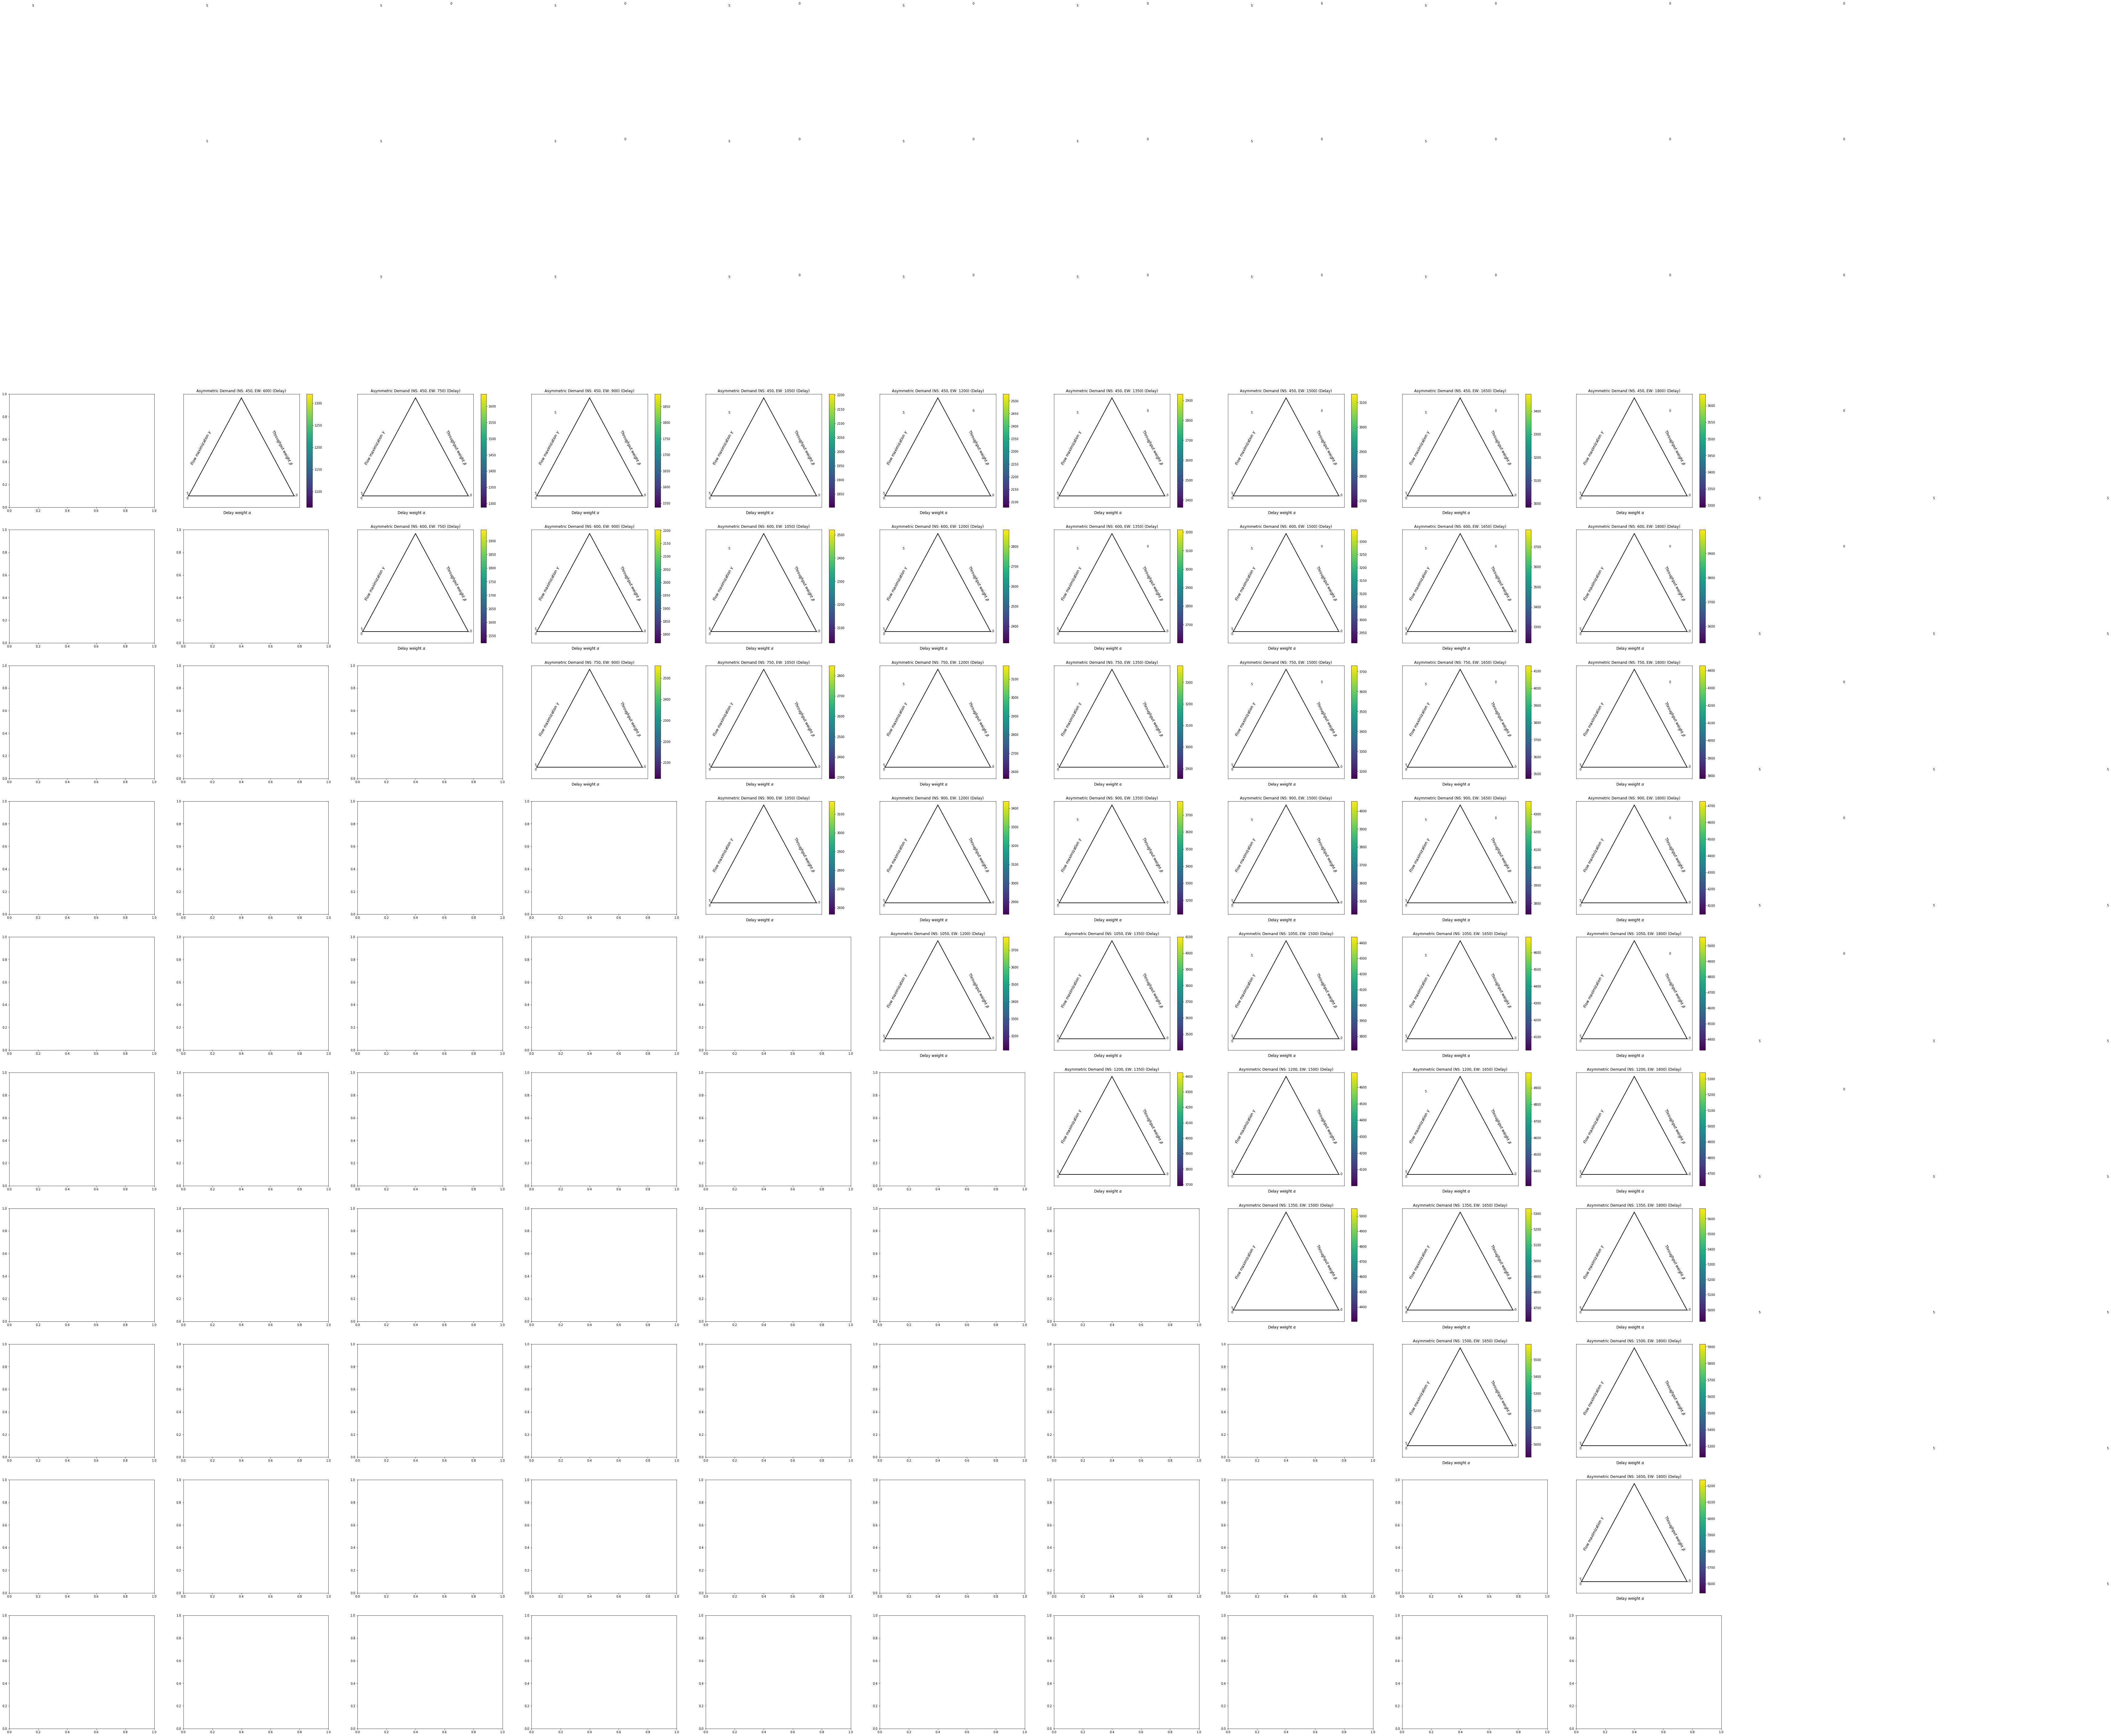

In [12]:
fig, axs = plt.subplots(10, 10)
fig.set_size_inches(100, 80)

for ndx, x in enumerate(single_demands):
    for ndy, y in enumerate(single_demands):
        if y <= x:
            continue
        
        df = pd.read_pickle("dataframes/asymm_demand/results_simplex_d({}, {}).pkl".format(x, y))
        df_nparr = df.values
        delay_dict = {}

        for row in df_nparr:
            delay_dict[(row[-3]*10, row[-2]*10, row[-1]*10)] = row[2]

        gg.plot_simplex(delay_dict, "Asymmetric Demand (NS: {}, EW: {}) (Delay)".format(x, y), "none", tax=ternary.TernaryAxesSubplot(ax=axs[ndx][ndy]))
        
fig.savefig("testbig.png")
plt.close(fig)

In [5]:
for d in demands:
    df = pd.read_pickle("dataframes/asymm_demand/results_simplex_d({}, {}).pkl".format(d[0], d[1]))
    gg.plot_obj_values(df, "Asymmetric demand (NS {}, EW {})".format(d[0], d[1]), filename_partial='{}_{}_demand'.format(d[0], d[1]))